This is my take to implement ConvNets to solve CIFAR10 classification task

# Fully Connected Network

## Load data

For this part I use Stanfords CS231n gugid to load the cifar10 data

In [1]:
from fullyConnected import early_stop, build_fc_model_batchnorm, build_CNN, build_CNN_batchnorm
from fullyConnected import build_2xCNN_batchnorm, build_CNN_nopool, update_functions
from fullyConnected import build_fc_model, update_functions, shared_dataset
from lasagne.layers import  get_all_param_values, count_params, get_all_layers, get_all_params
import numpy as np
from data_utils import get_CIFAR10_data
import theano.tensor as T
import time
import cPickle as pickle
# plot the training results
import matplotlib.pyplot as plt
%matplotlib inline

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5005)


In [2]:
# to auto reload external modules
%load_ext autoreload
%autoreload 2

In [3]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


## MLP

In [4]:
num_class = np.unique(data['y_train']).size

X = T.ftensor4('X')
y = T.ivector('y')

In [5]:
# load data to gpu for fast minibatch training
shared_data = shared_dataset(data)
del data

In [8]:
# build model
# here i only use a normal MLP, you shoudln't expect very good results
# 50% test accuracy is a good result here
input_shape = (None, 3,32,32)
hidden_arch = [64,128,256]

network = build_fc_model(in_shape=input_shape,
                         num_hidden=hidden_arch,
                         num_out=num_class,
                         in_var=X)

In [12]:
net,test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                     data=shared_data,
                                                                                     X=X, y=y,
                                                                                     batch_size=2048,
                                                                                     l1_reg=0,
                                                                                     l2_reg=.01,
                                                                                     lear_rate=1e-3,
                                                                                     iteration=100,
                                                                                     printFreq=20)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 24
start training
epoch 1, val_loss 1.603677, train_loss 1.723107, error 0.557000, best error 0.557000 ,in 0.163427 secs 

epoch 21, val_loss 1.553563, train_loss 1.499415, error 0.537000, best error 0.482000 ,in 3.148137 secs 

epoch 41, val_loss 1.481901, train_loss 1.513407, error 0.524000, best error 0.482000 ,in 3.155068 secs 

epoch 61, val_loss 1.493237, train_loss 1.516923, error 0.515000, best error 0.472000 ,in 3.149929 secs 

epoch 81, val_loss 1.557146, train_loss 1.495328, error 0.526000, best error 0.472000 ,in 3.142401 secs 



In [13]:
min(train_loss_history_), min(val_loss_history_), min(val_error_history_)

(1.4699889, array(1.3689178228378296, dtype=float32), array(0.472))

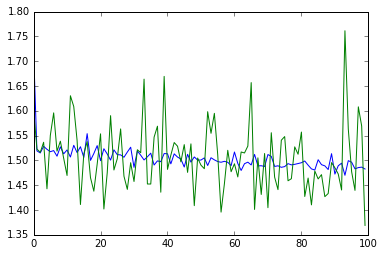

In [14]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [15]:
print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 52.8 %
best test accuracy: 53.2 %


## Add Dropout

In [16]:
# build model
# here i only use a normal MLP, you shoudln't expect very good results
# 50% test accuracy is a good result here
# note that Dropout helps to regularize the network, therefore
# it should not improve performance if the architecture is fixed as the previous model
input_shape = (None, 3,32,32)
hidden_arch = [64,128,256]
dropout = [.1,.3,.3]

network = build_fc_model(in_shape=input_shape,
                         num_hidden=hidden_arch,
                         num_out=num_class,
                         dropout=dropout,
                         in_var=X)

In [24]:
net,test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                     data=shared_data,
                                                                                     X=X, y=y,
                                                                                     batch_size=2048,
                                                                                     l1_reg=0,
                                                                                     l2_reg=.01,
                                                                                     lear_rate=1e-3,
                                                                                     iteration=100,
                                                                                     printFreq=20)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 24
start training
epoch 1, val_loss 1.538582, train_loss 1.711603, error 0.534000, best error 0.534000 ,in 0.290551 secs 

epoch 21, val_loss 1.502558, train_loss 1.647700, error 0.519000, best error 0.499000 ,in 5.619328 secs 

epoch 41, val_loss 1.512357, train_loss 1.648814, error 0.528000, best error 0.491000 ,in 5.887325 secs 

epoch 61, val_loss 1.663144, train_loss 1.650641, error 0.556000, best error 0.491000 ,in 6.076196 secs 

epoch 81, val_loss 1.401283, train_loss 1.649262, error 0.484000, best error 0.484000 ,in 5.978246 secs 



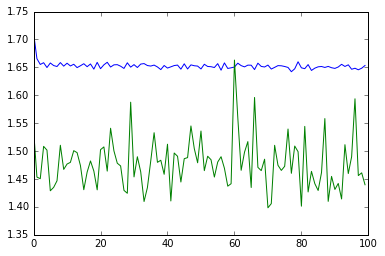

In [25]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [26]:
print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 51.6 %
best test accuracy: 48.0 %


## batch normalisation

Here I add batch normalisation to the MLP model, without any convolution layer, to see what happens.
I don't expect to drastic change as the batch-normalisation technique speeds-up learning, and not much more.

In [18]:
# build model
# here i only use a normal MLP, you shoudln't expect very good results
# 50% test accuracy is a good result here
input_shape = (None, 3,32,32)
hidden_arch = [64,128,256]

network = build_fc_model_batchnorm(in_shape=input_shape,
                                   num_hidden=hidden_arch,
                                   num_out=num_class,
                                   in_var=X)

In [21]:
net,test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                     data=shared_data,
                                                                                     X=X, y=y,
                                                                                     batch_size=2048,
                                                                                     l1_reg=0,
                                                                                     l2_reg=.01,
                                                                                     lear_rate=1e-3,
                                                                                     iteration=100,
                                                                                     printFreq=20)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 24
start training
epoch 1, val_loss 1.424564, train_loss 1.758554, error 0.495000, best error 0.495000 ,in 0.291607 secs 

epoch 21, val_loss 1.504065, train_loss 1.661150, error 0.536000, best error 0.478000 ,in 5.706652 secs 

epoch 41, val_loss 1.428217, train_loss 1.663188, error 0.503000, best error 0.478000 ,in 5.639629 secs 

epoch 61, val_loss 1.429774, train_loss 1.662209, error 0.509000, best error 0.478000 ,in 5.818938 secs 

epoch 81, val_loss 1.440475, train_loss 1.653599, error 0.510000, best error 0.478000 ,in 5.985794 secs 



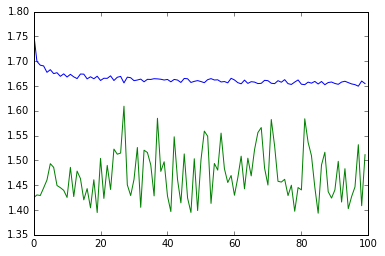

In [22]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [23]:
print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 52.2 %
best test accuracy: 46.5 %


# CNN

Build a simple 3layer CNN

architechture:
    conv - relu - 2x2 maxpool - affine - relu - affine - softmax
    
Note that I only use a single convolution layer, here we can see what is changing compared to previous models.
One convolution layer only can see a very small spatioal region in the image, here a 7x7 region. 
It is interesting to see how it compares to a fully connected network.

In [12]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = [128,256]
num_filter = 32

network = build_CNN(in_shape=input_shape,
                    num_hidden=hidden_arch,
                    num_filter = num_filter,
                    fil_size = 7,
                    num_out=num_class,
                    in_var=X)

In [16]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=128,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.001,
                                                                                 lear_rate=1e-3,
                                                                                 iteration=100,
                                                                                 printFreq=20)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 383
start training
epoch 1, val_loss 1.412611, train_loss 1.522405, error 0.522000, best error 0.522000 ,in 3.415571 secs 

epoch 21, val_loss 1.298695, train_loss 1.205357, error 0.430000, best error 0.402000 ,in 68.630920 secs 

epoch 41, val_loss 1.192607, train_loss 1.166085, error 0.402000, best error 0.385000 ,in 69.168571 secs 

epoch 61, val_loss 1.173393, train_loss 1.148397, error 0.391000, best error 0.370000 ,in 69.391259 secs 

epoch 81, val_loss 1.155466, train_loss 1.137996, error 0.394000, best error 0.369000 ,in 68.495842 secs 



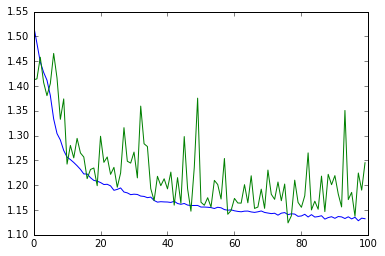

In [17]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [19]:
# using only one convolution layer we get better performance from network
print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 63.1 %
best test accuracy: 60.9 %


## CNN + Batch normalisation

Build a simple 3layer CNN with batch normalisation

architechture:

    conv - relu - 2x2 maxpool - affine - relu - affine - softmax
    
Here I try to see the improvement of batch normalisation added to the previous model.
Note that using the guid line of the original paper, I increase the learning rate nd decrease the regularization factor.

In [22]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = [128,256]
num_filter = 32

network = build_CNN_batchnorm(in_shape=input_shape,
                              num_hidden=hidden_arch,
                              num_filter = num_filter,
                              fil_size = 7,
                              num_out=num_class,
                              in_var=X)

In [23]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=128,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.0001,
                                                                                 lear_rate=1e-2,
                                                                                 iteration=100,
                                                                                 printFreq=20)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 383
start training
epoch 1, val_loss 1.190382, train_loss 1.474517, error 0.379000, best error 0.379000 ,in 5.813212 secs 

epoch 21, val_loss 1.749458, train_loss 0.274766, error 0.358000, best error 0.344000 ,in 116.065721 secs 

epoch 41, val_loss 1.703537, train_loss 0.249831, error 0.361000, best error 0.326000 ,in 115.854108 secs 

epoch 61, val_loss 1.800112, train_loss 0.234629, error 0.340000, best error 0.315000 ,in 115.532391 secs 

epoch 81, val_loss 1.664192, train_loss 0.220790, error 0.343000, best error 0.315000 ,in 115.402596 secs 



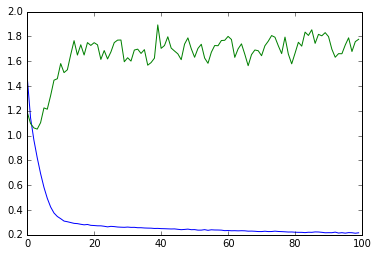

In [26]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [28]:
# Batch normalisation improved the performance

print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 68.5 %
best test accuracy: 64.4 %


## Deeper CNN + Batch normalisation
Build a simple 4layer CNN with batch normalisation

fist conv layer has 7x7 filters and the second has 3x3 filters

architechture:

        (conv - relu - 2x2 maxpool)x2 - affine - relu - affine - softmax

In [40]:
# build model
input_shape = (None, 3,32,32)
hidden_arch = 256
num_filter = [32,64]
filter_size = [7,5]
network = build_2xCNN_batchnorm(in_shape=input_shape,
                              num_hidden=hidden_arch,
                              num_filter = num_filter,
                              fil_size = filter_size,
                              num_out=num_class,
                              in_var=X)

In [41]:
net, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                 data=shared_data,
                                                                                 X=X, y=y,
                                                                                 batch_size=128,
                                                                                 l1_reg=0,
                                                                                 l2_reg=0.0001,
                                                                                 lear_rate=1e-2,
                                                                                 iteration=100,
                                                                                 printFreq=20)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 383
start training
epoch 1, val_loss 1.131011, train_loss 1.430652, error 0.370000, best error 0.370000 ,in 9.535417 secs 

epoch 21, val_loss 1.199109, train_loss 0.204532, error 0.294000, best error 0.282000 ,in 196.197937 secs 

epoch 41, val_loss 1.308090, train_loss 0.176949, error 0.286000, best error 0.267000 ,in 195.053981 secs 

epoch 61, val_loss 1.180299, train_loss 0.165021, error 0.283000, best error 0.267000 ,in 198.822055 secs 

epoch 81, val_loss 1.348595, train_loss 0.155663, error 0.299000, best error 0.264000 ,in 197.093655 secs 



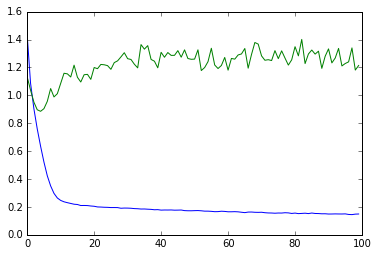

In [42]:
plt.plot(train_loss_history_)
plt.plot(val_loss_history_)

In [44]:
# Deeper CNN has more spatial information to work with, hence performance improves

print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 74.2 %
best test accuracy: 72.8 %


# Build a simpler CNN by avoiding pooling

Here I try to replicate the approach in [ref](http://arxiv.org/pdf/1412.6806.pdf). However, I added batch normalisation to the mix.

basically instead of pooling convolutions with stride 2 are used. In addition, fully connected layer is omitted

In [10]:
# build model
input_shape = (None, 3,32,32)

network = build_CNN_nopool(in_shape=input_shape,
                           num_filter=[32,64,96,96,128],
                           fil_size=  [ 7, 5, 3, 3,  3],
                           strides=   [ 1, 2, 1, 2,  1],                                                  
                           num_out=num_class,
                           in_var=X)

In [11]:
count_params(network)

369130

In [12]:
network, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                          data=shared_data,
                                                                                          X=X, y=y,
                                                                                          batch_size=512,
                                                                                          l1_reg=0,
                                                                                          l2_reg=0.0002,
                                                                                          lear_rate=1e-2,
                                                                                          iteration=100,
                                                                                          printFreq=20)


shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 96
start training
epoch 1, val_loss 1.684435, train_loss 5.051122, error 0.606000, best error 0.606000 ,in 15.126627 secs 

epoch 21, val_loss 1.070151, train_loss 0.951142, error 0.321000, best error 0.321000 ,in 300.458071 secs 

epoch 41, val_loss 1.008045, train_loss 0.901529, error 0.286000, best error 0.270000 ,in 300.252842 secs 

epoch 61, val_loss 1.303422, train_loss 0.868978, error 0.354000, best error 0.254000 ,in 300.403560 secs 

epoch 81, val_loss 1.117811, train_loss 0.839613, error 0.280000, best error 0.231000 ,in 300.322033 secs 



In [17]:
# continue training for a bit more with a smaller learning rate
network2, test_fn, train_loss_history2_, val_loss_history2_, val_error_history_2 = early_stop(net=network,
                                                                                              data=shared_data,
                                                                                              X=X, y=y,
                                                                                              batch_size=512,
                                                                                              l1_reg=0,
                                                                                              l2_reg=0.0002,
                                                                                              lear_rate=1e-3,
                                                                                              iteration=10,
                                                                                              printFreq=2)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 96
start training
epoch 1, val_loss 0.672183, train_loss 0.640716, error 0.195000, best error 0.195000 ,in 14.944637 secs 

epoch 3, val_loss 0.701191, train_loss 0.505578, error 0.191000, best error 0.186000 ,in 30.586258 secs 

epoch 5, val_loss 0.719980, train_loss 0.437595, error 0.189000, best error 0.186000 ,in 30.130817 secs 

epoch 7, val_loss 0.724530, train_loss 0.383423, error 0.191000, best error 0.186000 ,in 30.092684 secs 

epoch 9, val_loss 0.720379, train_loss 0.337466, error 0.189000, best error 0.186000 ,in 30.165180 secs 



In [20]:
# Deeper CNN has more spatial information to work with, hence performance improves

print "best val  accuracy:", (1-min(val_error_history_2))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 81.4 %
best test accuracy: 82.8 %


In [29]:
# continue training for a bit more with a smaller learning rate and smaller regularizer
network3, test_fn, train_loss_history3_, val_loss_history3_, val_error_history_3 = early_stop(net=network2,
                                                                                              data=shared_data,
                                                                                              X=X, y=y,
                                                                                              batch_size=128,
                                                                                              l1_reg=0,
                                                                                              l2_reg=0.0003,
                                                                                              lear_rate=1e-4,
                                                                                              iteration=10,
                                                                                              printFreq=2)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 383
start training
epoch 1, val_loss 0.804650, train_loss 0.384254, error 0.186000, best error 0.186000 ,in 18.014590 secs 

epoch 3, val_loss 0.763553, train_loss 0.355357, error 0.186000, best error 0.186000 ,in 35.988742 secs 

epoch 5, val_loss 0.734288, train_loss 0.330039, error 0.183000, best error 0.183000 ,in 36.007531 secs 

epoch 7, val_loss 0.713538, train_loss 0.307731, error 0.183000, best error 0.182000 ,in 35.980991 secs 

epoch 9, val_loss 0.699132, train_loss 0.287893, error 0.187000, best error 0.182000 ,in 35.958730 secs 



In [30]:
# Deeper CNN has more spatial information to work with, hence performance improves

print "best val  accuracy:", (1-min(val_error_history_3))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 81.8 %
best test accuracy: 82.6 %


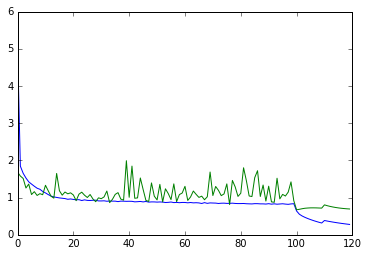

In [33]:
plt.plot(train_loss_history_+ train_loss_history2_+ train_loss_history3_)
plt.plot(val_loss_history_+val_loss_history2_+val_loss_history3_)

In [16]:
# # if you want to continue from a previous run
# with open("fullCNN.p", "rb") as f:
#     _,train_loss_history_,val_loss_history_, val_error_history_,network = pickle.load(f)
# X = get_all_layers(network)[0].input_var

In [15]:
# # evaluate test prediction
# _, val_fn, test_fn = update_functions(net=network,data=shared_data,
#                                       in_var=X, target=y)


# Very deep all Conv network 

In [115]:
# build model
input_shape = (None, 3,32,32)

network = build_CNN_nopool(in_shape=input_shape,nlin_func=leaky,
                           num_filter=[64,64,64,128,128,128,256,256,256,512],
                           fil_size=  [ 2, 2, 2,  2,  2,  2,  2,  2,  2,  1],
                           strides=   [ 1, 1, 2,  1,  1,  2,  1,  1,  2,  1],
                           num_out=num_class,
                           in_var=X)

In [116]:
count_params(network)

1405962

In [119]:
network, test_fn, train_loss_history_, val_loss_history_, val_error_history_ = early_stop(net=network,
                                                                                          data=shared_data,
                                                                                          X=X, y=y,
                                                                                          batch_size=128,
                                                                                          l1_reg=0,
                                                                                          l2_reg=0.0002,
                                                                                          lear_rate=1e-3,
                                                                                          iteration=50,
                                                                                          printFreq=10)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 383
start training
epoch 1, val_loss 0.845884, train_loss 0.769862, error 0.256000, best error 0.256000 ,in 89.046192 secs 

epoch 11, val_loss 1.227578, train_loss 0.587779, error 0.244000, best error 0.237000 ,in 890.154851 secs 

epoch 21, val_loss 1.144575, train_loss 0.523805, error 0.226000, best error 0.222000 ,in 890.467596 secs 

epoch 31, val_loss 1.198867, train_loss 0.479242, error 0.245000, best error 0.212000 ,in 890.476292 secs 

epoch 41, val_loss 1.145471, train_loss 0.444623, error 0.218000, best error 0.207000 ,in 890.558271 secs 



In [121]:
# Deeper CNN has more spatial information to work with, hence performance improves

print "best val  accuracy:", (1-min(val_error_history_))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

 best val  accuracy: 79.3 %
best test accuracy: 76.7 %


In [122]:
network2, test_fn, train_loss_history_2, val_loss_history_2, val_error_history_2 = early_stop(net=network,
                                                                                              data=shared_data,
                                                                                              X=X, y=y,
                                                                                              batch_size=128,
                                                                                              l1_reg=0,
                                                                                              l2_reg=0.0003,
                                                                                              lear_rate=1e-4,
                                                                                              iteration=50,
                                                                                              printFreq=10)

shape training (49000, 3, 32, 32) 

shape validation (1000, 3, 32, 32) 

validation_frequency 383
start training
epoch 1, val_loss 0.846764, train_loss 0.522066, error 0.175000, best error 0.175000 ,in 88.778588 secs 

epoch 11, val_loss 0.741563, train_loss 0.324791, error 0.168000, best error 0.167000 ,in 891.321986 secs 

epoch 21, val_loss 0.689535, train_loss 0.215095, error 0.163000, best error 0.160000 ,in 891.395508 secs 

epoch 31, val_loss 0.677011, train_loss 0.145409, error 0.172000, best error 0.160000 ,in 891.449190 secs 

epoch 41, val_loss 0.687130, train_loss 0.100711, error 0.173000, best error 0.160000 ,in 898.536430 secs 



In [128]:
# Deeper CNN has more spatial information to work with, hence performance improves

print "best val  accuracy:", (1-min(val_error_history_2))*100,"%"
print "best test accuracy:", (1-test_fn()[1])*100,"%"

best val  accuracy: 84.0 %
best test accuracy: 82.5 %


In [129]:
pickle.dump([network, test_fn, train_loss_history_, val_loss_history_, val_error_history_,
             network2, test_fn, train_loss_history_2, val_loss_history_2, val_error_history_2],
                                     open("deepestmodel.p", "wb"))

In [137]:
with open("deepestmodel.p", "rb") as f:
    network,_,_,_, _,network2,_,_,_,_ = pickle.load(f)

In [138]:
network3, test_fn, train_loss_history_3, val_loss_history_3, val_error_history_3 = early_stop(net=network2,
                                                                                              data=shared_data,
                                                                                              X=X, y=y,
                                                                                              batch_size=128,
                                                                                              l1_reg=0,
                                                                                              l2_reg=0.0004,
                                                                                              lear_rate=1e-4,
                                                                                              iteration=10,
                                                                                              printFreq=2)

UnusedInputError: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 2 is not part of the computational graph needed to compute the outputs: <CudaNdarrayType(float32, 4D)>.
To make this error into a warning, you can pass the parameter on_unused_input='warn' to theano.function. To disable it completely, use on_unused_input='ignore'.

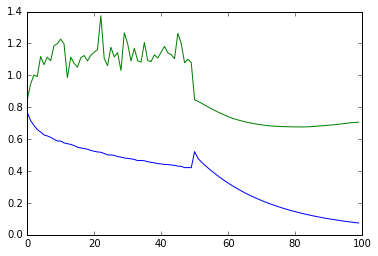

In [132]:
plt.plot(train_loss_history_+ train_loss_history_2)#+ train_loss_history3_)
plt.plot(val_loss_history_+val_loss_history_2)#+val_loss_history3_)

# Residual layers

Here I experiment with residual layers, the original paper proposing residual layeres is [here](https://arxiv.org/abs/1512.03385)